### Streaming:

 Methods: stream() and astream()
* These methods are sync and async methods for streaming back results.

Additional parameters in streaming mode for graph state:
* values: This streams the full state of the graph after each node is called
* updates: This streams updates to the state of the graph after each node is called.

In [9]:
#simple chatbot to show streaming techniques

import os
from dotenv import load_dotenv
load_dotenv()

from langchain.chat_models import init_chat_model

from typing_extensions import TypedDict
from typing import Annotated, List
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph, START, END

from pprint import pprint

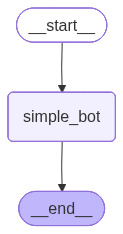

In [5]:
#defining state schema

class State(TypedDict):
    messages: Annotated[List, add_messages]


#node definition

def simple_bot(state:State):
    model = init_chat_model(model="groq:llama-3.1-8b-instant")
    return {"messages": model.invoke(state['messages'])}

#graph builder

graph = StateGraph(State)

graph.add_node("simple_bot", simple_bot)

graph.add_edge(START, "simple_bot")
graph.add_edge("simple_bot", END)

graph_builder = graph.compile()
graph_builder


In [13]:
#streaming values

response = graph_builder.stream({"messages":"say a funny joke"}, stream_mode="values")
for event in response:
    print(event)

{'messages': [HumanMessage(content='say a funny joke', additional_kwargs={}, response_metadata={}, id='e3081429-3572-4c81-afbf-ff665c1d06d6')]}
{'messages': [HumanMessage(content='say a funny joke', additional_kwargs={}, response_metadata={}, id='e3081429-3572-4c81-afbf-ff665c1d06d6'), AIMessage(content='A man walked into a library and asked the librarian, "Do you have any books on Pavlov\'s dogs and Schrödinger\'s cat?" \n\nThe librarian replied, "It rings a bell, but I\'m not sure if it\'s here or not."', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 39, 'total_tokens': 94, 'completion_time': 0.046099805, 'completion_tokens_details': None, 'prompt_time': 0.002276931, 'prompt_tokens_details': None, 'queue_time': 0.056362889, 'total_time': 0.048376736}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_

In [14]:
response = graph_builder.stream({"messages":"say a funny joke"}, stream_mode="updates")
for event in response:
    print(event)

{'simple_bot': {'messages': AIMessage(content='A man walked into a library and asked the librarian, "Do you have any books on Pavlov\'s dogs and Schrödinger\'s cat?" The librarian replied, "It rings a bell, but I\'m not sure if it\'s here or not."', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 39, 'total_tokens': 93, 'completion_time': 0.049350208, 'completion_tokens_details': None, 'prompt_time': 0.002471178, 'prompt_tokens_details': None, 'queue_time': 0.051558302, 'total_time': 0.051821386}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b3c04-09cf-77e2-a5f0-1a4e98aa0f0b-0', usage_metadata={'input_tokens': 39, 'output_tokens': 54, 'total_tokens': 93})}}


##### default stream_mode is "updates"

In [18]:
# apart from messages, we might sometimes need additional info, like metadata of event.
# this can be generated using "astream_events()" method.


async for event in graph_builder.astream_events({"messages":"say a funny joke"}, stream_mode="updates"):
    print(event)


{'event': 'on_chain_start', 'data': {'input': {'messages': 'say a funny joke'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '019b3c07-d4fb-7021-9d1b-4ae51516634e', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='say a funny joke', additional_kwargs={}, response_metadata={}, id='2f811c03-a926-4486-9221-46424c246315')]}}, 'name': 'simple_bot', 'tags': ['graph:step:1'], 'run_id': '019b3c07-d4fd-7d21-b911-bde08feb8fda', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'simple_bot', 'langgraph_triggers': ('branch:to:simple_bot',), 'langgraph_path': ('__pregel_pull', 'simple_bot'), 'langgraph_checkpoint_ns': 'simple_bot:8131896c-b757-4f11-246d-aa2d6b0a5daa'}, 'parent_ids': ['019b3c07-d4fb-7021-9d1b-4ae51516634e']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='say a funny joke', additional_kwargs={}, response_metadata={}, id='2f811c03-a926-4486-9221-46424c246315')]]}}, 'name': 'Cha

Each event is a dict with few keys:
* event: This is the type of event that is being emitted.
* name: This is the name of the event.
* data: This is the data associated with the event.
* metadata: contains langgraph_node, the node emitting the event.